# Overview
- This notebook is the Watson Studio notebook for the Advanced Data Science Capstone project of Coursera.
- The topic of this project is the "IEEE-CIS Fraud Detection" challenge from Kaggle, more information about the dataset and the competition can be found at https://www.kaggle.com/c/ieee-fraud-detection/
- The Machine Learning model in this Notebook is developped using the tensorflow/keras integrated in the Watson Studio Notebook. In addition, other libraries are used for the data analysis, graph display, data preprocessing:
    + numpy
    + pandas
    + scikit-learn
    + matplotlib
    + seaborn
- This model is developped using only the data from the train_transaction.csv, meaning just have of the given data.
- In order to evaluate the performance of the model, F1_score function is developped.
- In order to optimize the training/testing, we have to update to tensorflow 2.
- Updated the evaluation and METRICS using the tutorials of tensorflow at https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

# Update tensorflow 2 and other libraries

In [1]:
!pip install tensorflow==2.2.0 seaborn==0.10.1 numpy==1.18.5 tensorflow-addons

# Load the dataset from the Cloud Data Object

In [10]:
# The code was removed by Watson Studio for sharing.

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
body = client_a5b8370d070043a698d332a3da4f29ba.get_object(Bucket='advanceddatasciencecapstoneprojec-donotdelete-pr-sxgni1jmo8dtzj',Key='train_identity.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

dataset_identity = pd.read_csv(body)
dataset_identity.head(5)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


# Import the libraries

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import os
import tensorflow as tf

# Remove the features with too many NaN or with two many objects for the OneHotEncoding

In [13]:
#Data transaction
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
to_remove_NaN_dataset_transaction = []

for column in float_columns:
  count_NaN = np.sum(np.isnan(dataset_transaction[column].values))
  if count_NaN/len(dataset_transaction[column].values) > 0.75:
    to_remove_NaN_dataset_transaction.append(column)
    dataset_transaction.pop(column)

print("No. of removed features: " + str(len(to_remove_NaN_dataset_transaction)))

No. of removed features: 167


In [14]:
# Dataset Identity
float_columns = dataset_identity.columns[np.where(dataset_identity.dtypes == np.dtype('float64'))].to_list()
to_remove_NaN_dataset_identity = []

for column in float_columns:
  count_NaN = np.sum(np.isnan(dataset_identity[column].values))
  if count_NaN/len(dataset_identity[column]) > 0.75:
    to_remove_NaN_dataset_identity.append(column)
    dataset_identity.pop(column)

print("No. of removed features: " + str(len(to_remove_NaN_dataset_identity)))

No. of removed features: 7


In [15]:
to_remove_id = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in to_remove_id:
  dataset_identity.pop(column)

# Merge the dataframe, cleansing (using OneHotEncoding) and Normalize the data

In [16]:
merged_data = pd.merge(left=dataset_transaction, right=dataset_identity, how='left', left_on='TransactionID', right_on='TransactionID')

dataset_transaction = None
dataset_identity = None
merged_data.shape

(590540, 256)

In [17]:
merged_data.tail(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590539,3577539,0,15811131,279.95,W,15066,170.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
dataset_transaction = copy.copy(merged_data)
merged_data = None
dataset_identity = None

float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

cache = dict()
print(len(float_columns), len(int_columns), len(obj_columns))

225 2 27


In [19]:
def normalization_data(X, indices):
  X_out = copy.copy(X)
  X_temp = X[indices]
  max_X = np.max(X_temp)
  min_X = np.min(X_temp)
  mean_X = np.mean(X_temp)
  X_out.iloc[indices] = (X_temp - mean_X)/(max_X - min_X)
  X_out.iloc[np.where(np.isnan(X_out))[0]] = 0.0

  return min_X, max_X, mean_X, X_out.astype('float16')

In [20]:
# Task 1: Detect the columns with NaN and code it with an extra features
# Task 2: Apply normalizationn
# Task 3: Remove the irrelevant columns
for column in float_columns:
  # Set to float 16
  dataset_transaction[column].astype('float32')

  # Code the NaN column for every features
  dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)
  dataset_transaction[column].astype('float16')

In [21]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_09_NaN_Code,id_10_NaN_Code,id_11_NaN_Code,id_13_NaN_Code,id_14_NaN_Code,id_17_NaN_Code,id_18_NaN_Code,id_19_NaN_Code,id_20_NaN_Code,id_32_NaN_Code
0,2987000,0,86400,-0.002083,W,13926,0.000000,-0.024384,discover,-0.418213,...,1,1,1,1,1,1,1,1,1,1
1,2987001,0,86401,-0.003321,W,2755,0.082886,-0.024384,mastercard,-0.709961,...,1,1,1,1,1,1,1,1,1,1
2,2987002,0,86469,-0.002380,W,4663,0.254883,-0.024384,visa,-0.242920,...,1,1,1,1,1,1,1,1,1,1
3,2987003,0,86499,-0.002663,W,18132,0.408936,-0.024384,mastercard,-0.600586,...,1,1,1,1,1,1,1,1,1,1
4,2987004,0,86506,-0.002663,H,4497,0.302979,-0.024384,mastercard,-0.709961,...,1,1,0,1,0,0,1,0,0,0


In [22]:
for column in int_columns:
  # Set to int 32
  dataset_transaction[column].astype('float32')

  # Code the NaN feature
  dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [23]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_11_NaN_Code,id_13_NaN_Code,id_14_NaN_Code,id_17_NaN_Code,id_18_NaN_Code,id_19_NaN_Code,id_20_NaN_Code,id_32_NaN_Code,TransactionDT_NaN_Code,card1_NaN_Code
0,2987000,0,-0.463379,-0.002083,W,0.231445,0.000000,-0.024384,discover,-0.418213,...,1,1,1,1,1,1,1,1,0,0
1,2987001,0,-0.463379,-0.003321,W,-0.410645,0.082886,-0.024384,mastercard,-0.709961,...,1,1,1,1,1,1,1,1,0,0
2,2987002,0,-0.463379,-0.002380,W,-0.301025,0.254883,-0.024384,visa,-0.242920,...,1,1,1,1,1,1,1,1,0,0
3,2987003,0,-0.463379,-0.002663,W,0.473389,0.408936,-0.024384,mastercard,-0.600586,...,1,1,1,1,1,1,1,1,0,0
4,2987004,0,-0.463379,-0.002663,H,-0.310547,0.302979,-0.024384,mastercard,-0.709961,...,0,1,0,0,1,0,0,0,0,0


In [24]:
from sklearn.preprocessing import OneHotEncoder

encoded_column = 0
for column in obj_columns:
  ohc = OneHotEncoder()
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(dataset_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(dataset_transaction[column].astype('str'))))])
  dataset_transaction = pd.concat([dataset_transaction, pd_encoded], axis=1)
  cache[column] = dataset_transaction[column].values.reshape(-1,1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))
for column in obj_columns:
  try:
    dataset_transaction.pop(column)
  except KeyError:
    pass

Encoded columns: 207


In [25]:
# Double check again Null and Nan
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


# Apply Seaborn to analyze the processed data and detect removable features

In [26]:
out = ['isFraud']
for column in dataset_transaction.columns:
  if column.find('R_emaildomain') != -1:
    out.append(column)
  if column.find('P_emaildomain') != -1:
    out.append(column)

In [27]:
columns_to_analyze = out
analyzing_data = dataset_transaction[columns_to_analyze]

In [ ]:
corr = analyzing_data.corr()

# Note: Switch this to True to see the heat map of the corr
# Note: This step can also be done with other features, however, for the Capstone project, we will only remove the features generated by the OneHotEncoding step
to_display = False

if to_display:
  mask = np.triu(np.ones_like(corr, dtype=np.bool))
  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Remove the weak correlation features created by the OneHotEncoding step
col = corr.columns
is_fraud = np.where(col=='isFraud')[0][0]
col = col.to_list()
col.pop(is_fraud)
to_remove = []
for each_col in col:
  if abs(corr['isFraud'][each_col]) < 0.01: # Weak correlation
    to_remove.append(each_col)
    a = dataset_transaction.pop(each_col)
print(len(to_remove))
analyzing_data = None

dataset_transaction.head(5)

99


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,2987000,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,...,0,0,1,0,0,1,0,1,0,0
1,2987001,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,...,0,0,1,0,0,1,0,1,0,0
2,2987002,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,...,0,0,1,0,0,1,0,1,0,0
3,2987003,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,...,0,0,1,0,0,1,0,1,0,0
4,2987004,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,...,0,0,0,1,0,0,1,0,0,1


# Create the train/val dataset

In [ ]:
dataset = copy.copy(dataset_transaction)

# Remove the irrelevant columns
a = dataset.pop('TransactionID')
dataset.head(5)

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,id_36_2,id_37_0,id_37_1,id_37_2,id_38_0,id_38_1,id_38_2,DeviceType_0,DeviceType_1,DeviceType_2
0,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,...,0,0,1,0,0,1,0,1,0,0
1,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,...,0,0,1,0,0,1,0,1,0,0
2,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,...,0,0,1,0,0,1,0,1,0,0
3,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,...,0,0,1,0,0,1,0,1,0,0
4,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,...,0,0,0,1,0,0,1,0,0,1


In [ ]:
from sklearn.model_selection import train_test_split

Y = dataset['isFraud']
dataset.pop('isFraud')
X = dataset
X_train = X
Y_train = Y

Percentage of Fraud: 3.5%


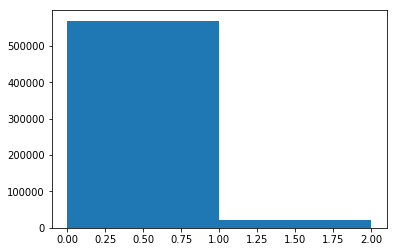

In [ ]:
# Check the imbalance
plt.hist(Y_train, bins=[0,1,2])

fraud_count = np.unique(Y_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# Downsampling/Upsampling to minimize the imbalance 

In [ ]:
downsampling_factor = 1
indices_1 = np.argwhere(np.array(Y_train)==1)
indices_0_new = np.argwhere(np.array(Y_train)==0)
indices = np.arange(0,len(indices_0_new),downsampling_factor)
indices_0_new = indices_0_new[indices]

print(indices_0_new.shape)

upsampling_factor = 10
indices_1_new = indices_1
for i in range(upsampling_factor):
  indices_1_new = np.concatenate((indices_1_new, indices_1), axis=0)

indices_0_new = np.concatenate((indices_1_new, indices_0_new), axis=0)

indices_0_new = tf.random.shuffle(indices_0_new)

X_new = np.array(X_train)[indices_0_new]
Y_new = np.array(Y_train)[indices_0_new]

X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y_new, test_size=0.01)

X_to_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[2]))
Y_to_train = np.squeeze(Y_train, axis=1)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[2]))
Y_test = np.squeeze(Y_test, axis=1)


print(X_to_train.shape, X_test.shape)

(569877, 1)
(789198, 562) (7972, 562)


Percentage of Fraud: 28.51%


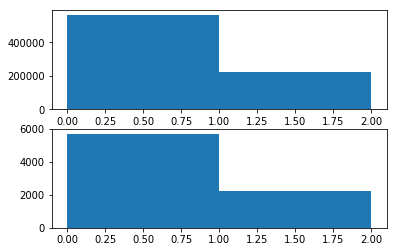

In [ ]:
X_new = None
Y_new = None

plt.subplot(211)
plt.hist(Y_to_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_test, bins=[0,1,2])

X_train = None
Y_train = None
X = None
Y = None

fraud_count = np.unique(Y_to_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# Create the model using NN

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def create_model(dense1=128, dense2=64, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001):
  out_model = Sequential()
  
  out_model.add(Dense(dense1, activation='relu',
                      input_shape=(X_to_train.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())
  out_model.add(Dense(dense1, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense2, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(1, activation="sigmoid"))

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=[METRICS])
  
  return out_model

In [ ]:
my_model = create_model(dense1=256, dense2=128, dropout_rate=0.4, l1_rate=1e-3, l2_rate=8e-4, init_std=0.01, lr=0.00002)
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               144128    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

# Perform the training and using the callbacks to optimize the performance of the final model

In [ ]:
BATCH_SIZE = 512
NB_EPOCH = 2000
PATIENCE = 20

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=PATIENCE, verbose=0, mode='max',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='./best_model.h5', monitor='val_auc', verbose=1, save_best_only=True,
    save_weights_only=False, mode='max')

history = my_model.fit(X_to_train, Y_to_train, verbose=0,
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.01, shuffle=True,
             callbacks=[early_stop, best_model_hold])


Epoch 00001: val_auc improved from -inf to 0.86599, saving model to ./best_model.h5

Epoch 00002: val_auc improved from 0.86599 to 0.88267, saving model to ./best_model.h5

Epoch 00003: val_auc improved from 0.88267 to 0.88956, saving model to ./best_model.h5

Epoch 00004: val_auc improved from 0.88956 to 0.89523, saving model to ./best_model.h5

Epoch 00005: val_auc improved from 0.89523 to 0.89771, saving model to ./best_model.h5

Epoch 00006: val_auc improved from 0.89771 to 0.90285, saving model to ./best_model.h5

Epoch 00007: val_auc improved from 0.90285 to 0.90344, saving model to ./best_model.h5

Epoch 00008: val_auc improved from 0.90344 to 0.90672, saving model to ./best_model.h5

Epoch 00009: val_auc improved from 0.90672 to 0.90960, saving model to ./best_model.h5

Epoch 00010: val_auc improved from 0.90960 to 0.91082, saving model to ./best_model.h5

Epoch 00011: val_auc improved from 0.91082 to 0.91285, saving model to ./best_model.h5

Epoch 00012: val_auc improved from

# The lost and the training cuvre

In [ ]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1) 
    plt.plot(history.epoch,  history.history[metric], color='b', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

# F1_score function and validate the test set

In [ ]:
new_model = tf.keras.models.load_model('./best_weights.h5')
new_model.summary()

In [ ]:

def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = test_size
  y_pred = (model.predict(X_test, batch_size=128)>threshold).astype(int)
  y_pred = np.squeeze(y_pred, axis=1)
 
  precision = precision_cal(y_pred, y_ref)
  recall = recall_cal(y_pred, y_ref)

  return precision, recall, 2*precision*recall/(precision+recall)

In [ ]:
pre = []
re = []
f1 = []

pre_train = []
re_train = []
f1_train = []

threshold_value = []
indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

for i in range(90):
  threshold_value.append(0.1+i*0.01)
  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_test, Y_test, test_size=len(Y_test), threshold=threshold_value[-1])
  
  pre.append(temp_pre)
  re.append(temp_re)
  f1.append(temp_f1)

  temp_pre, temp_re, temp_f1 = F1_score(new_model, X_to_train[indices], Y_to_train[indices], test_size=len(Y_to_train[indices]), threshold=threshold_value[-1])

  pre_train.append(temp_pre)
  re_train.append(temp_re)
  f1_train.append(temp_f1)

In [ ]:
plt.plot(threshold_value, f1, 'b')
plt.plot(threshold_value, pre, 'r')
plt.plot(threshold_value, re, 'g')

plt.plot(threshold_value, f1_train, '--b')
plt.plot(threshold_value, pre_train, '--r')
plt.plot(threshold_value, re_train, '--g')

max_f1_indices = np.where(f1==np.max(f1))[0][0]
print("Best F1 score is " + str(f1[max_f1_indices]) + " at threshold of " + str(threshold_value[max_f1_indices]))

In [ ]:
def plot_cm(labels, predictions, p=0.5, display=True):
  cm = confusion_matrix(labels, predictions > p)
  if display:
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
  pre = cm[1][1]/(cm[1][1] + cm[0][1])
  recall = cm[1][1]/(cm[1][1] + cm[1][0])
  f1_score = 2*pre*recall/(pre+recall)
  return pre, recall, f1_score

In [ ]:
BATCH_SIZE = 256
baseline_results = new_model.evaluate(X_test, Y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(new_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

predictions = new_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

plot_cm(Y_test, predictions, p=threshold_value[max_f1_indices], display=True)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,30])
  plt.ylim([70,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

indices = np.random.randint(0, len(X_to_train), size=(len(Y_test),))

train_prediction = new_model.predict(X_to_train[indices], batch_size=BATCH_SIZE, verbose=0)
plot_roc("Train Baseline", Y_to_train[indices], train_prediction, color='b')
plot_roc("Test Baseline", Y_test, predictions, color='b', linestyle='--')
plt.legend(loc='lower right')

In [ ]:
prediction = np.squeeze(predictions, axis=1)
threshold = threshold_value[max_f1_indices]
plt.subplot(211)
plt.hist(Y_test, bins=[0,1,2])

plt.subplot(212)
plt.hist((prediction>threshold).astype('int'), bins=[0,1,2])

fraud_predict = np.unique((prediction>threshold).astype('int'), return_counts=True)
fraud_real = np.unique(Y_test, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_predict[1][1]/np.sum(fraud_predict[1])*100,2)) + "% " + str(round(fraud_real[1][1]/np.sum(fraud_real[1])*100,2)) + "%")

# Evaluate the performance of the model using the Kaggle tools

In [ ]:
body = client_a5b8370d070043a698d332a3da4f29ba.get_object(Bucket='advanceddatasciencecapstoneprojec-donotdelete-pr-sxgni1jmo8dtzj',Key='test_transaction.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test_transaction = pd.read_csv(body)
test_transaction.head(5)

# Remove transaction ID
TransactionID = test_transaction.pop('TransactionID')

In [ ]:
body = client_a5b8370d070043a698d332a3da4f29ba.get_object(Bucket='advanceddatasciencecapstoneprojec-donotdelete-pr-sxgni1jmo8dtzj',Key='test_identity.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test_identity = pd.read_csv(body)
test_identity.head()


In [ ]:
dataset_transaction = None
to_remove_id = ['DeviceInfo', 'id_30', 'id_31', 'id_33']
for column in to_remove_id:
  a = test_identity.pop(column)

# Remove the columns in to_remove_NaN_dataset_transaction and to_remove_NaN_dataset_identity
for column in to_remove_NaN_dataset_transaction:
  test_transaction.pop(column)

for column in to_remove_NaN_dataset_identity:
  test_identity.pop(column)


In [ ]:
merged_data = pd.merge(left=test_transaction, right=test_identity, how='left', left_on='TransactionID', right_on='TransactionID')

TransactionID = merged_data.pop('TransactionID')
test_transaction = None
merged_data.shape

In [ ]:
merged_data.head(5)

In [ ]:
test_transaction = copy.copy(merged_data)
merged_data = None
float_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns_test = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('O'))].to_list()

print(len(float_columns_test), len(int_columns_test), len(obj_columns_test))

In [ ]:
def apply_normalization(X, indices, cache_min, cache_max, cache_mean):
  X_out = copy.copy(X)
  X_out[indices] = (X_out[indices] - cache_mean)/(cache_max - cache_min)
  X_out[np.where(np.isnan(X_out))[0]] = 0.0
  return X_out.astype('float16')

In [ ]:
for column in float_columns_test:
  # Set to float 16
  test_transaction[column].astype('float32')

  # Code the NaN feature
  test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [ ]:
for column in int_columns_test:
  # Set to int 32
  test_transaction[column].astype('int32')

  # Code the NaN feature
  test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X.to_numpy(), indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [ ]:
encoded_column = 0
for column in obj_columns_test:
  ohc = OneHotEncoder(handle_unknown='ignore')
  ohc.fit(cache[column])
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.transform(test_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(cache[column])))])
  test_transaction = pd.concat([test_transaction, pd_encoded], axis=1)
  encoded_column += len(pd_encoded.columns)

print("Encoded columns: " + str(encoded_column))


for column in obj_columns_test:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass

In [ ]:
# Check if we have the same shape with the X_train
print(test_transaction.shape, X_train.shape)

In [ ]:
# Make the prediction and submit the output
threshold = threshold_value[max_f1_indices]
result = (new_model.predict(test_transaction)>threshold).astype('int8')
result_pd = pd.DataFrame(result, columns=['isFraud'])
data_to_file = pd.concat([TransactionID, result_pd], axis=1)
data_to_file.head(5)
data_to_file.to_csv("./submission.csv", index=False)

In [ ]:
!pip install kaggle

In [ ]:
!echo '{"Your Kaggle information here"}' > kaggle.json
os.environ['KAGGLE_CONFIG_DIR'] = "./"

In [ ]:
!kaggle competitions submit -c ieee-fraud-detection -f submission.csv -m "Submission, {threshold}"

# The model reached a public score of ~0.8 with a patience of 50 for the training, this can be improved by increasing the patience or having a better model